In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/crelu1'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

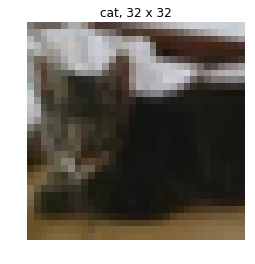

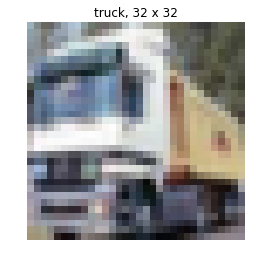

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_crelu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.nn.crelu)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=tf.nn.crelu)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.nn.crelu)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=tf.nn.crelu)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_crelu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/crelu1
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/crelu1/model.ckpt
INFO:tensorflow:

INFO:tensorflow:global step 810: loss = 1.1203 (0.141 sec/step)
INFO:tensorflow:global step 820: loss = 1.0898 (0.146 sec/step)
INFO:tensorflow:global step 830: loss = 1.2428 (0.132 sec/step)
INFO:tensorflow:global step 840: loss = 1.1546 (0.150 sec/step)
INFO:tensorflow:global step 850: loss = 1.0056 (0.147 sec/step)
INFO:tensorflow:global step 860: loss = 1.0818 (0.142 sec/step)
INFO:tensorflow:global step 870: loss = 0.9416 (0.154 sec/step)
INFO:tensorflow:global step 880: loss = 0.8976 (0.139 sec/step)
INFO:tensorflow:global step 890: loss = 1.0074 (0.146 sec/step)
INFO:tensorflow:global step 900: loss = 0.9281 (0.160 sec/step)
INFO:tensorflow:global step 910: loss = 0.9640 (0.140 sec/step)
INFO:tensorflow:global step 920: loss = 0.9989 (0.157 sec/step)
INFO:tensorflow:global step 930: loss = 0.9996 (0.148 sec/step)
INFO:tensorflow:global step 940: loss = 1.0942 (0.142 sec/step)
INFO:tensorflow:global step 950: loss = 1.1056 (0.132 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global_step/sec: 6.77999
INFO:tensorflow:Recording summary at step 2033.
INFO:tensorflow:global step 2040: loss = 0.5085 (0.146 sec/step)
INFO:tensorflow:global step 2050: loss = 0.5098 (0.143 sec/step)
INFO:tensorflow:global step 2060: loss = 0.6942 (0.160 sec/step)
INFO:tensorflow:global step 2070: loss = 0.5802 (0.154 sec/step)
INFO:tensorflow:global step 2080: loss = 0.7062 (0.152 sec/step)
INFO:tensorflow:global step 2090: loss = 0.6095 (0.138 sec/step)
INFO:tensorflow:global step 2100: loss = 0.5861 (0.140 sec/step)
INFO:tensorflow:global step 2110: loss = 0.5433 (0.161 sec/step)
INFO:tensorflow:global step 2120: loss = 0.9214 (0.141 sec/step)
INFO:tensorflow:global step 2130: loss = 0.6386 (0.132 sec/step)
INFO:tensorflow:global step 2140: loss = 0.4936 (0.140 sec/step)
INFO:tensorflow:global step 2150: loss = 0.7086 (0.136 sec/step)
INFO:tensorflow:global step 2160: loss = 0.8344 (0.138 sec/step)
INFO:tensorflow:global step 2170: loss = 0.5410 (0.145 sec/step)
I

INFO:tensorflow:global step 3270: loss = 0.5532 (0.143 sec/step)
INFO:tensorflow:global step 3280: loss = 0.6196 (0.141 sec/step)
INFO:tensorflow:global step 3290: loss = 0.5314 (0.148 sec/step)
INFO:tensorflow:global step 3300: loss = 0.5354 (0.150 sec/step)
INFO:tensorflow:global step 3310: loss = 0.5058 (0.132 sec/step)
INFO:tensorflow:global step 3320: loss = 0.5978 (0.154 sec/step)
INFO:tensorflow:global step 3330: loss = 0.4302 (0.136 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3399 (0.148 sec/step)
INFO:tensorflow:global step 3350: loss = 0.5858 (0.136 sec/step)
INFO:tensorflow:global step 3360: loss = 0.5447 (0.143 sec/step)
INFO:tensorflow:global step 3370: loss = 0.6425 (0.137 sec/step)
INFO:tensorflow:global step 3380: loss = 0.5443 (0.146 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/crelu1/model.ckpt
INFO:tensorflow:global_step/sec: 6.77999
INFO:tensorflow:global step 3390: loss = 0.5601 (0.183 sec/step)
INFO:tensorflow:Recording summary at step

INFO:tensorflow:global step 4490: loss = 0.5029 (0.145 sec/step)
INFO:tensorflow:global step 4500: loss = 0.4132 (0.140 sec/step)
INFO:tensorflow:global step 4510: loss = 0.3967 (0.151 sec/step)
INFO:tensorflow:global step 4520: loss = 0.3182 (0.148 sec/step)
INFO:tensorflow:global step 4530: loss = 0.4883 (0.139 sec/step)
INFO:tensorflow:global step 4540: loss = 0.5207 (0.154 sec/step)
INFO:tensorflow:global step 4550: loss = 0.6929 (0.151 sec/step)
INFO:tensorflow:global step 4560: loss = 0.5461 (0.146 sec/step)
INFO:tensorflow:global step 4570: loss = 0.4992 (0.138 sec/step)
INFO:tensorflow:global step 4580: loss = 0.6163 (0.136 sec/step)
INFO:tensorflow:global step 4590: loss = 0.4678 (0.141 sec/step)
INFO:tensorflow:global step 4600: loss = 0.2995 (0.140 sec/step)
INFO:tensorflow:global step 4610: loss = 0.4491 (0.140 sec/step)
INFO:tensorflow:global step 4620: loss = 0.2936 (0.145 sec/step)
INFO:tensorflow:global step 4630: loss = 0.4194 (0.151 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5710: loss = 0.4267 (0.154 sec/step)
INFO:tensorflow:global step 5720: loss = 0.5338 (0.146 sec/step)
INFO:tensorflow:global step 5730: loss = 0.6847 (0.152 sec/step)
INFO:tensorflow:global step 5740: loss = 0.4035 (0.142 sec/step)
INFO:tensorflow:global step 5750: loss = 0.3001 (0.141 sec/step)
INFO:tensorflow:global step 5760: loss = 0.4556 (0.144 sec/step)
INFO:tensorflow:global step 5770: loss = 0.5874 (0.148 sec/step)
INFO:tensorflow:global step 5780: loss = 0.3792 (0.163 sec/step)
INFO:tensorflow:global step 5790: loss = 0.2899 (0.141 sec/step)
INFO:tensorflow:global step 5800: loss = 0.3929 (0.136 sec/step)
INFO:tensorflow:global step 5810: loss = 0.2486 (0.140 sec/step)
INFO:tensorflow:global step 5820: loss = 0.3734 (0.159 sec/step)
INFO:tensorflow:global step 5830: loss = 0.3447 (0.149 sec/step)
INFO:tensorflow:global step 5840: loss = 0.7310 (0.143 sec/step)
INFO:tensorflow:global step 5850: loss = 0.3447 (0.143 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6930: loss = 0.3392 (0.147 sec/step)
INFO:tensorflow:global step 6940: loss = 0.4158 (0.145 sec/step)
INFO:tensorflow:global step 6950: loss = 0.3787 (0.139 sec/step)
INFO:tensorflow:global step 6960: loss = 0.2864 (0.144 sec/step)
INFO:tensorflow:global step 6970: loss = 0.2260 (0.145 sec/step)
INFO:tensorflow:global step 6980: loss = 0.3747 (0.136 sec/step)
INFO:tensorflow:global step 6990: loss = 0.2504 (0.157 sec/step)
INFO:tensorflow:global step 7000: loss = 0.4732 (0.148 sec/step)
INFO:tensorflow:global step 7010: loss = 0.4888 (0.164 sec/step)
INFO:tensorflow:global step 7020: loss = 0.1684 (0.141 sec/step)
INFO:tensorflow:global step 7030: loss = 0.3914 (0.168 sec/step)
INFO:tensorflow:global step 7040: loss = 0.4488 (0.146 sec/step)
INFO:tensorflow:global step 7050: loss = 0.4056 (0.142 sec/step)
INFO:tensorflow:global step 7060: loss = 0.6312 (0.156 sec/step)
INFO:tensorflow:global step 7070: loss = 0.2717 (0.145 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8160: loss = 0.2208 (0.139 sec/step)
INFO:tensorflow:global step 8170: loss = 0.2693 (0.152 sec/step)
INFO:tensorflow:global step 8180: loss = 0.5700 (0.135 sec/step)
INFO:tensorflow:global step 8190: loss = 0.3441 (0.135 sec/step)
INFO:tensorflow:global step 8200: loss = 0.3405 (0.147 sec/step)
INFO:tensorflow:global step 8210: loss = 0.3462 (0.150 sec/step)
INFO:tensorflow:global step 8220: loss = 0.5433 (0.164 sec/step)
INFO:tensorflow:global step 8230: loss = 0.3496 (0.143 sec/step)
INFO:tensorflow:global step 8240: loss = 0.2410 (0.139 sec/step)
INFO:tensorflow:global step 8250: loss = 0.2845 (0.147 sec/step)
INFO:tensorflow:global step 8260: loss = 0.4333 (0.155 sec/step)
INFO:tensorflow:global step 8270: loss = 0.2131 (0.142 sec/step)
INFO:tensorflow:global step 8280: loss = 0.6159 (0.151 sec/step)
INFO:tensorflow:global step 8290: loss = 0.2517 (0.152 sec/step)
INFO:tensorflow:global step 8300: loss = 0.4280 (0.157 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9410: loss = 0.2103 (0.134 sec/step)
INFO:tensorflow:global step 9420: loss = 0.2966 (0.143 sec/step)
INFO:tensorflow:global step 9430: loss = 0.3150 (0.142 sec/step)
INFO:tensorflow:global step 9440: loss = 0.2842 (0.142 sec/step)
INFO:tensorflow:global step 9450: loss = 0.2166 (0.157 sec/step)
INFO:tensorflow:global step 9460: loss = 0.3671 (0.139 sec/step)
INFO:tensorflow:global step 9470: loss = 0.2841 (0.150 sec/step)
INFO:tensorflow:global step 9480: loss = 0.3083 (0.137 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/crelu1/model.ckpt
INFO:tensorflow:global step 9490: loss = 0.2660 (0.201 sec/step)
INFO:tensorflow:Recording summary at step 9490.
INFO:tensorflow:global step 9500: loss = 0.3154 (0.158 sec/step)
INFO:tensorflow:global step 9510: loss = 0.1694 (0.146 sec/step)
INFO:tensorflow:global step 9520: loss = 0.1715 (0.134 sec/step)
INFO:tensorflow:global step 9530: loss = 0.3588 (0.141 sec/step)
INFO:tensorflow:global step 9540: 

INFO:tensorflow:global step 10630: loss = 0.1794 (0.144 sec/step)
INFO:tensorflow:global step 10640: loss = 0.3195 (0.144 sec/step)
INFO:tensorflow:global step 10650: loss = 0.2906 (0.135 sec/step)
INFO:tensorflow:global step 10660: loss = 0.5879 (0.136 sec/step)
INFO:tensorflow:global step 10670: loss = 0.1511 (0.146 sec/step)
INFO:tensorflow:global step 10680: loss = 0.2938 (0.134 sec/step)
INFO:tensorflow:global step 10690: loss = 0.3319 (0.149 sec/step)
INFO:tensorflow:global step 10700: loss = 0.1684 (0.140 sec/step)
INFO:tensorflow:global step 10710: loss = 0.2696 (0.137 sec/step)
INFO:tensorflow:global step 10720: loss = 0.1547 (0.141 sec/step)
INFO:tensorflow:global step 10730: loss = 0.1992 (0.165 sec/step)
INFO:tensorflow:global step 10740: loss = 0.2900 (0.157 sec/step)
INFO:tensorflow:global step 10750: loss = 0.2056 (0.149 sec/step)
INFO:tensorflow:global step 10760: loss = 0.1563 (0.137 sec/step)
INFO:tensorflow:global step 10770: loss = 0.1570 (0.146 sec/step)
INFO:tenso

INFO:tensorflow:global step 11840: loss = 0.1091 (0.143 sec/step)
INFO:tensorflow:global step 11850: loss = 0.1775 (0.147 sec/step)
INFO:tensorflow:global step 11860: loss = 0.2406 (0.142 sec/step)
INFO:tensorflow:global step 11870: loss = 0.2622 (0.147 sec/step)
INFO:tensorflow:global step 11880: loss = 0.2914 (0.133 sec/step)
INFO:tensorflow:global step 11890: loss = 0.3001 (0.142 sec/step)
INFO:tensorflow:global step 11900: loss = 0.5162 (0.139 sec/step)
INFO:tensorflow:global step 11910: loss = 0.4503 (0.142 sec/step)
INFO:tensorflow:global step 11920: loss = 0.4276 (0.141 sec/step)
INFO:tensorflow:global step 11930: loss = 0.1815 (0.148 sec/step)
INFO:tensorflow:global step 11940: loss = 0.2210 (0.153 sec/step)
INFO:tensorflow:global step 11950: loss = 0.1701 (0.159 sec/step)
INFO:tensorflow:global step 11960: loss = 0.1777 (0.143 sec/step)
INFO:tensorflow:global step 11970: loss = 0.1331 (0.163 sec/step)
INFO:tensorflow:global step 11980: loss = 0.2148 (0.135 sec/step)
INFO:tenso

INFO:tensorflow:global step 13050: loss = 0.1982 (0.136 sec/step)
INFO:tensorflow:global step 13060: loss = 0.2002 (0.147 sec/step)
INFO:tensorflow:global step 13070: loss = 0.1911 (0.151 sec/step)
INFO:tensorflow:global step 13080: loss = 0.3898 (0.155 sec/step)
INFO:tensorflow:global step 13090: loss = 0.1622 (0.145 sec/step)
INFO:tensorflow:global step 13100: loss = 0.2477 (0.140 sec/step)
INFO:tensorflow:global step 13110: loss = 0.4277 (0.152 sec/step)
INFO:tensorflow:global step 13120: loss = 0.5583 (0.162 sec/step)
INFO:tensorflow:global step 13130: loss = 0.1929 (0.155 sec/step)
INFO:tensorflow:global step 13140: loss = 0.3320 (0.161 sec/step)
INFO:tensorflow:global step 13150: loss = 0.0622 (0.145 sec/step)
INFO:tensorflow:global step 13160: loss = 0.2803 (0.139 sec/step)
INFO:tensorflow:global step 13170: loss = 0.4054 (0.147 sec/step)
INFO:tensorflow:global step 13180: loss = 0.2936 (0.142 sec/step)
INFO:tensorflow:global step 13190: loss = 0.3689 (0.141 sec/step)
INFO:tenso

INFO:tensorflow:global step 14260: loss = 0.1915 (0.154 sec/step)
INFO:tensorflow:global step 14270: loss = 0.3790 (0.138 sec/step)
INFO:tensorflow:global step 14280: loss = 0.2778 (0.143 sec/step)
INFO:tensorflow:global step 14290: loss = 0.4122 (0.155 sec/step)
INFO:tensorflow:global step 14300: loss = 0.3315 (0.134 sec/step)
INFO:tensorflow:global step 14310: loss = 0.6531 (0.157 sec/step)
INFO:tensorflow:global step 14320: loss = 0.2088 (0.134 sec/step)
INFO:tensorflow:global step 14330: loss = 0.3039 (0.148 sec/step)
INFO:tensorflow:global step 14340: loss = 0.1990 (0.140 sec/step)
INFO:tensorflow:global step 14350: loss = 0.1061 (0.141 sec/step)
INFO:tensorflow:global step 14360: loss = 0.2218 (0.143 sec/step)
INFO:tensorflow:global step 14370: loss = 0.1557 (0.158 sec/step)
INFO:tensorflow:global step 14380: loss = 0.1810 (0.136 sec/step)
INFO:tensorflow:global step 14390: loss = 0.3975 (0.152 sec/step)
INFO:tensorflow:global step 14400: loss = 0.3354 (0.150 sec/step)
INFO:tenso

INFO:tensorflow:global step 15490: loss = 0.1802 (0.149 sec/step)
INFO:tensorflow:global step 15500: loss = 0.3268 (0.132 sec/step)
INFO:tensorflow:global step 15510: loss = 0.2820 (0.137 sec/step)
INFO:tensorflow:global step 15520: loss = 0.1152 (0.134 sec/step)
INFO:tensorflow:global step 15530: loss = 0.2858 (0.138 sec/step)
INFO:tensorflow:global step 15540: loss = 0.1629 (0.131 sec/step)
INFO:tensorflow:global step 15550: loss = 0.0901 (0.152 sec/step)
INFO:tensorflow:global step 15560: loss = 0.1119 (0.143 sec/step)
INFO:tensorflow:global step 15570: loss = 0.2466 (0.136 sec/step)
INFO:tensorflow:global step 15580: loss = 0.1529 (0.153 sec/step)
INFO:tensorflow:global step 15590: loss = 0.1456 (0.138 sec/step)
INFO:tensorflow:global step 15600: loss = 0.1611 (0.137 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/crelu1/model.ckpt
INFO:tensorflow:Recording summary at step 15606.
INFO:tensorflow:global step 15610: loss = 0.4788 (0.152 sec/step)
INFO:tensorflow:glob

INFO:tensorflow:global step 16700: loss = 0.1658 (0.155 sec/step)
INFO:tensorflow:global step 16710: loss = 0.5321 (0.144 sec/step)
INFO:tensorflow:global step 16720: loss = 0.1481 (0.147 sec/step)
INFO:tensorflow:global step 16730: loss = 0.1586 (0.146 sec/step)
INFO:tensorflow:global step 16740: loss = 0.1357 (0.135 sec/step)
INFO:tensorflow:global step 16750: loss = 0.2452 (0.135 sec/step)
INFO:tensorflow:global step 16760: loss = 0.1309 (0.144 sec/step)
INFO:tensorflow:global step 16770: loss = 0.0604 (0.145 sec/step)
INFO:tensorflow:global step 16780: loss = 0.1066 (0.148 sec/step)
INFO:tensorflow:global step 16790: loss = 0.1706 (0.151 sec/step)
INFO:tensorflow:global step 16800: loss = 0.0473 (0.145 sec/step)
INFO:tensorflow:global step 16810: loss = 0.2231 (0.158 sec/step)
INFO:tensorflow:global step 16820: loss = 0.0568 (0.148 sec/step)
INFO:tensorflow:global step 16830: loss = 0.4970 (0.151 sec/step)
INFO:tensorflow:global step 16840: loss = 0.2465 (0.146 sec/step)
INFO:tenso

INFO:tensorflow:global step 17910: loss = 0.4754 (0.138 sec/step)
INFO:tensorflow:global step 17920: loss = 0.2979 (0.153 sec/step)
INFO:tensorflow:global step 17930: loss = 0.2801 (0.147 sec/step)
INFO:tensorflow:global step 17940: loss = 0.1219 (0.139 sec/step)
INFO:tensorflow:global step 17950: loss = 0.1570 (0.142 sec/step)
INFO:tensorflow:global step 17960: loss = 0.0518 (0.145 sec/step)
INFO:tensorflow:global step 17970: loss = 0.2062 (0.159 sec/step)
INFO:tensorflow:global step 17980: loss = 0.1826 (0.138 sec/step)
INFO:tensorflow:global step 17990: loss = 0.1088 (0.142 sec/step)
INFO:tensorflow:global step 18000: loss = 0.1898 (0.146 sec/step)
INFO:tensorflow:global step 18010: loss = 0.2833 (0.145 sec/step)
INFO:tensorflow:global step 18020: loss = 0.1493 (0.141 sec/step)
INFO:tensorflow:global step 18030: loss = 0.1548 (0.145 sec/step)
INFO:tensorflow:global step 18040: loss = 0.0478 (0.145 sec/step)
INFO:tensorflow:global step 18050: loss = 0.2933 (0.142 sec/step)
INFO:tenso

INFO:tensorflow:global step 19120: loss = 0.1415 (0.135 sec/step)
INFO:tensorflow:global step 19130: loss = 0.3597 (0.149 sec/step)
INFO:tensorflow:global step 19140: loss = 0.1427 (0.144 sec/step)
INFO:tensorflow:global step 19150: loss = 0.1056 (0.147 sec/step)
INFO:tensorflow:global step 19160: loss = 0.2498 (0.156 sec/step)
INFO:tensorflow:global step 19170: loss = 0.0950 (0.153 sec/step)
INFO:tensorflow:global step 19180: loss = 0.2990 (0.156 sec/step)
INFO:tensorflow:global step 19190: loss = 0.0980 (0.134 sec/step)
INFO:tensorflow:global step 19200: loss = 0.1382 (0.150 sec/step)
INFO:tensorflow:global step 19210: loss = 0.0475 (0.143 sec/step)
INFO:tensorflow:global step 19220: loss = 0.6593 (0.150 sec/step)
INFO:tensorflow:global step 19230: loss = 0.1140 (0.139 sec/step)
INFO:tensorflow:global step 19240: loss = 0.2746 (0.150 sec/step)
INFO:tensorflow:global step 19250: loss = 0.2364 (0.138 sec/step)
INFO:tensorflow:global step 19260: loss = 0.4257 (0.151 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_crelu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-03-17:30:51
INFO:tensorflow:Restoring parameters from /tmp/cifar10/crelu1/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-17:30:52
eval/TruePositives: 114.000000
eval/FalseNegatives: 5.000000
eval/TrueNegatives: 6.000000
eval/FalsePositives: 3.000000
eval/mse: 5.257812
eval/Accuracy: 0.773438
eval/Recall5: 0.945312
CPU times: user 1.86 s, sys: 352 ms, total: 2.21 s
Wall time: 1.29 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/crelu1/model.ckpt-20000


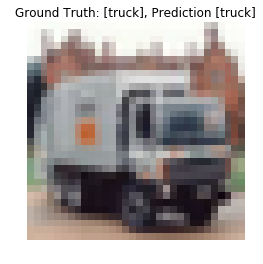

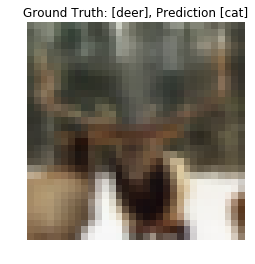

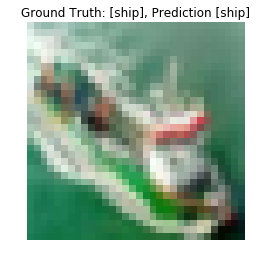

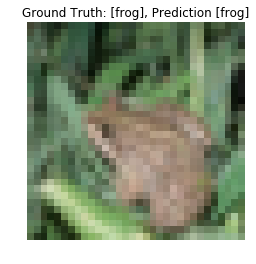

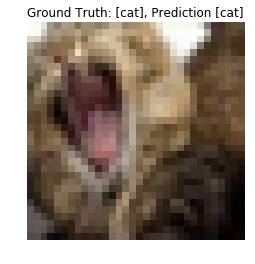

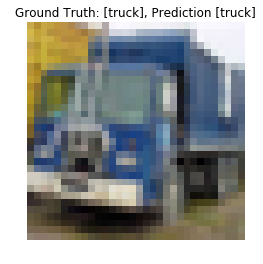

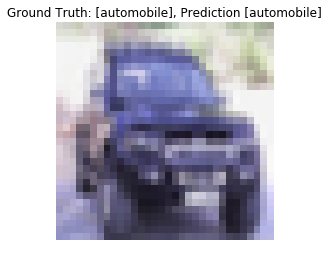

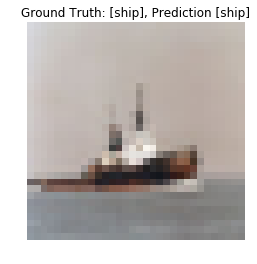

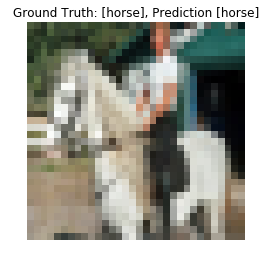

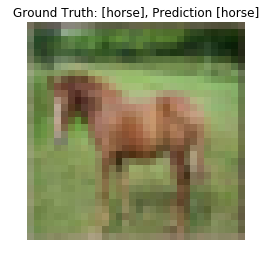

CPU times: user 3.22 s, sys: 1.78 s, total: 5 s
Wall time: 1.61 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_crelu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()